### Libraries

In [5]:
import os
os.environ.update(
 OMP_NUM_THREADS = '1',
 OPENBLAS_NUM_THREADS = '1',
 NUMEXPR_NUM_THREADS = '1',
 MKL_NUM_THREADS = '1')
import string
import re
import sys
from sys import argv
import os.path
import math
import subprocess
import pymatgen as mg
import shutil
import time
import itertools
import progressbar
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error
from itertools import combinations_with_replacement
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

# Change to your current working directory below
print('Current working directory path:',os.getcwd())
os.chdir("C:/Users/gpeters2/Desktop/FormationE")
print(os.getcwd())

Current working directory path: C:\Users\gpeters2\Desktop\FormationE
C:\Users\gpeters2\Desktop\FormationE


## Predictions

This cell only needs to be run once to lead the model and dataset descriptors, not for each new system

In [179]:
dataset_filename = 'MP_data'
descriptors_filename = 'descriptors_MP_data_elementsnew_onehot'

# Read in the descriptors for model training on known systems
DE = pd.read_excel(descriptors_filename+'.xlsx')
df = pd.read_excel(dataset_filename+'.xlsx')

#from joblib import dump,load

# Load command:
#model = load('RF-FormationE_MP_onehot_mf18-ne800.joblib')

#print(model)

array = DE.values
y=array[:,0]
X=array[:,1:]
DE.head()

print('Full descriptors dataset size: ',X.shape)
print('Full labels dataset size: ',y.shape)

Full descriptors dataset size:  (89642, 480)
Full labels dataset size:  (89642,)


In [182]:
# run if you want only compounds with formation energy < 1
DE = DE[DE['Value']<1]

In [32]:
# run if you want to look at compounds with particular elements in the training data
DE[DE['avg_Composition_Y']>0][DE['avg_Composition_In']>0][DE['avg_Composition_Ag']>0].head(50)

C:\Users\gpeters2\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Composition     Value  avg_Composition_Ag  avg_Composition_Al  \
69718      YInAg2 -0.378341                 0.5                 0.0   

       avg_Composition_Ar  avg_Composition_As  avg_Composition_Au  \
69718                   0                 0.0                 0.0   

       avg_Composition_B  avg_Composition_Ba  avg_Composition_Be  \
69718                0.0                 0.0                 0.0   

       avg_Composition_Bi  avg_Composition_Br  avg_Composition_C  \
69718                 0.0                 0.0                0.0   

       avg_Composition_Ca  avg_Composition_Cd  avg_Composition_Ce  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Cl  avg_Composition_Co  avg_Composition_Cr  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Cs  avg_Composition_Cu  avg_Composition_Dy  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Er  avg_Composition_Eu  avg_Composition_F  \
69718                 0.0                 0.0                0.0   

       avg_Composition_Fe  avg_Composition_Ga  avg_Composition_Gd  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Ge  avg_Composition_H  avg_Composition_He  \
69718                 0.0                0.0                   0   

       avg_Composition_Hf  avg_Composition_Hg  avg_Composition_Ho  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_I  avg_Composition_In  avg_Composition_Ir  \
69718                0.0                0.25                 0.0   

       avg_Composition_K  avg_Composition_Kr  avg_Composition_La  \
69718                0.0                   0                 0.0   

       avg_Composition_Li  avg_Composition_Lu  avg_Composition_Mg  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Mn  avg_Composition_Mo  avg_Composition_N  \
69718                 0.0                 0.0                0.0   

       avg_Composition_Na  avg_Composition_Nb  avg_Composition_Nd  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Ne  avg_Composition_Ni  avg_Composition_O  \
69718                   0                 0.0                0.0   

       avg_Composition_Os  avg_Composition_P  avg_Composition_Pb  \
69718                 0.0                0.0                 0.0   

       avg_Composition_Pd  avg_Composition_Pm  avg_Composition_Pr  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Pt  avg_Composition_Rb  avg_Composition_Re  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Rh  avg_Composition_Ru  avg_Composition_S  \
69718                 0.0                 0.0                0.0   

       avg_Composition_Sb  avg_Composition_Sc  avg_Composition_Se  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Si  avg_Composition_Sm  avg_Composition_Sn  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Sr  avg_Composition_Ta  avg_Composition_Tb  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_Tc  avg_Composition_Te  avg_Composition_Th  \
69718                   0                 0.0                 0.0   

       avg_Composition_Ti  avg_Composition_Tl  avg_Composition_Tm  \
69718                 0.0                 0.0                 0.0   

       avg_Composition_U  avg_Composition_V  avg_Composition_W  \
69718                0.0                0.0                0.0   

       avg_Composition_Xe  avg_Composition_Y  avg_Composition_Yb  \
69718                   0               0.25                 0.0   

       avg_Composition_Zn  avg_Composition_Zr  avg_ Atomic_Number  \
69718                 0.0                 0.0                45.5   


### Random Forest Predictions with Standard Dev.

In [215]:
elem, elem_list = 'value',[]
elements = ['','H','D','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og']
while elem != '':
    elem = input('Enter element (blank if done): ')
    if elem in elements:
        elem_list.append(elem)
    else:
        print('Element not found!')

# alphabetize element list
elem_list.sort()
elem_list.remove('')
system = ''
for elem in elem_list:
    system += elem
    
step = float(input('Step size % (default 5%): ') or 5)
n_steps = int((100)/step + 1)
steps = np.linspace(0,100,n_steps)
phases = []


# set number of trials to be averaged, number of trees in each forest, max features, and elements
n_samples = int(input('Number of independent RFs (default 10): ') or 10)
ne = int(input('Number of estimators per RF (default 400): ') or 400)
mf = int(input('Max number of features (default 15): ') or 15)

for phase in itertools.product(steps, repeat=len(elem_list)):
    if sum(map(round, phase)) == 100:
        phases.append(phase)
        
comps = []
for phase in phases:
    comp = ''
    comp_list = [elem+str(phase[n]) for n,elem in enumerate(elem_list)]
    for item in comp_list:
        comp += item
    comps.append((comp))
comps.append(''.join(elem+'1.0' for elem in elem_list))
comps_df = pd.DataFrame({'Composition':comps,'Value':np.zeros(len(comps))})
comps_df.to_excel('{0}_predict.xlsx'.format(system),index=False)

print('Done writing file: %s_predict.xlsx' % (system))

##### read in compounds list
df_grid = pd.read_excel(r'%s_predict.xlsx' % (system)) 

# Generate descriptors
class Vectorize_Formula:

    def __init__(self):
        elem_dict = pd.read_excel(r'elementsnew_onehot.xlsx') # CHECK NAME OF FILE 
        self.element_df = pd.DataFrame(elem_dict) 
        self.element_df.set_index('Symbol',inplace=True)
        self.column_names = []
        for string in ['avg','diff','max','min']:
            for column_name in list(self.element_df.columns.values):
                self.column_names.append(string+'_'+column_name)

    def get_features(self, formula):
        try:
            fractional_composition = mg.Composition(formula).fractional_composition.as_dict()
            element_composition = mg.Composition(formula).element_composition.as_dict()
            avg_feature = np.zeros(len(self.element_df.iloc[0]))
            for key in fractional_composition:
                try:
                    avg_feature += self.element_df.loc[key].values * fractional_composition[key]
                    diff_feature = self.element_df.loc[list(fractional_composition.keys())].max()-self.element_df.loc[list(fractional_composition.keys())].min()
                except Exception as e: 
                    print('The element:', key, 'from formula', formula,'is not currently supported in our database')
                    return np.array([np.nan]*len(self.element_df.iloc[0])*5)
            max_feature = self.element_df.loc[list(fractional_composition.keys())].max()
            min_feature = self.element_df.loc[list(fractional_composition.keys())].min()
            
            features = pd.DataFrame(np.concatenate([avg_feature, diff_feature, np.array(max_feature), np.array(min_feature)]))
            features = np.concatenate([avg_feature, diff_feature, np.array(max_feature), np.array(min_feature)])
            return features.transpose()
        except:
            print('There was an error with the Formula: '+ formula + ', this is a general exception with an unkown error')
            return [np.nan]*len(self.element_df.iloc[0])*5

        
gf=Vectorize_Formula()

# empty list for storage of features
features=[]

# empty list for storage of property values
targets=[]

print('Getting dataset features...',end = '',flush=True)
updater = 0

# add values to list using for loop
for formula, target in zip(df_grid['Composition'], df_grid['Value']):
    features.append(gf.get_features(formula))
    targets.append(target)
    updater = updater + 1
    if updater > 1000:
        print('.',end='',flush=True)
        updater = 0
print('Done!')
        
# feature vectors and targets as X and y 
target_X = pd.DataFrame(features, columns = gf.column_names)
target_y = pd.Series(targets)
pd.set_option('display.max_columns', None)


# drop elements that aren't included in the elemental properties list. 
# These will be returned as feature rows completely full of NaN values. 
target_X.dropna(inplace=True, how='all')
target_y=target_y.loc[target_X.index]

# reset dataframe indices to simplify code later.
target_X.reset_index(drop=True, inplace=True)
target_y.reset_index(drop=True, inplace=True)

# collect column names
cols = target_X.columns.values

# find the median value of each column
median_values = target_X[cols].median()

# fill missing values in each column with columns mean value
target_X[cols]=target_X[cols].fillna(median_values.iloc[0])
print('Data Shape:',target_X.shape)

# add formation energy targets to first column
target_X['Value'] = df_grid['Value']
target_X_cols = target_X.columns.tolist()
target_X_cols = target_X_cols[-1:] + target_X_cols[:-1]
target_X = target_X[target_X_cols]

# write xlsx file
print('Writing %s_descriptors.xlsx...' % (system), end = '', flush = True)                
target_X.to_excel('%s_descriptors.xlsx' % (system), index = None )
print('Done!')

print('Generating predictions...',end='',flush=True)

# initialize lists and read in descriptor file for targets
stats = []
values = []
val_stats = []
targets_DE = pd.read_excel('%s_descriptors.xlsx' % (system))
targets_X = targets_DE.values[:,1:]

# code block below is for parallelized training
'''
import multiprocessing
from multiprocessing import Pool
import Def_PredictionLoop
import time

in_vals = (X,y,targets_X,ne,mf)
in_list = [in_vals]*n_samples

start = time.time()

if __name__ == '__main__':
    with Pool() as pool:
        result = pool.starmap(Def_PredictionLoop.pred_loop,
                             in_list)
end = time.time()
print('\n')
print('Done in',round(end-start,10),'seconds!')


avg_values = np.zeros(len(result[0][0]))
std_values = np.zeros(len(result[0][0]))
for n in range(len(result[0][0])):
    avg_values[n] = np.average([trial[0][n] for trial in result])
    std_values[n] = np.std([trial[0][n] for trial in result])
    
# read in and store x values in 'x_vals' list
# (percent of alphabetically second element)
df_result = pd.read_excel('%s_predict.xlsx' % (system), index = None)
df_result['Value'],df_result['StDev'] = avg_values,std_values
#df_result.to_excel('%s_predict.xlsx' % (system))
df_result
'''

for i in progressbar.progressbar(range(n_samples)):

    # split the train and test data randomly and rescale to redetermine the model
    # similarly scale the target descriptors
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, shuffle=True)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    targets_X2 = scaler.transform(targets_X)
    
    # train the RF model on the training data
    model = RandomForestRegressor(n_jobs = 6, n_estimators = ne, max_features = mf)
    model.fit(X_train, y_train)
    predict_y = model.predict(X_test)
    
    # calculate the MSE and RMSE of the holdout data and store in 'stats'
    # calculate the predicted values for the targets and store in 'values'
    mse = mean_squared_error(y_test, predict_y)
    rmse = np.sqrt(mse)
    stats.append([model.score(X_train,y_train),model.score(X_test,y_test),mse,rmse])
    values.append(model.predict(targets_X2))

# create 'val_stats' list of mean and stdev for all targets
# stacking into one array (rather than array of arrays) allows slicing
values = np.stack(values)
err_low,err_high = [],[]
for i in range(len(values[0])):

    val_stats.append([np.average(values[:,i]),np.std(values[:,i])])
val_stats = np.stack(val_stats) 

# read in and store x values in 'x_vals' list
# (percent of alphabetically second element)
df_result = pd.read_excel('%s_predict.xlsx' % (system))
df_result['Value'],df_result['StDev'] = val_stats[:,0],val_stats[:,1]
df_result.to_excel('%s_predict_ol.xlsx' % (system))
df_result

Enter element (blank if done): Ca
Enter element (blank if done): Cu
Enter element (blank if done): Au
Enter element (blank if done): Ag
Enter element (blank if done): Al
Enter element (blank if done): 
Step size % (default 5%): 
Number of independent RFs (default 10): 3
Number of estimators per RF (default 400): 20
Max number of features (default 15): 
Done writing file: AgAlAuCaCu_predict.xlsx
Getting dataset features.............Done!
Data Shape: (10627, 480)
Writing AgAlAuCaCu_descriptors.xlsx...Done!
Generating predictions...

100% (3 of 3) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11


Composition     Value     StDev
0      Ag0.0Al0.0Au0.0Ca0.0Cu100.0 -0.000213  0.006877
1       Ag0.0Al0.0Au0.0Ca5.0Cu95.0 -0.030780  0.092873
2      Ag0.0Al0.0Au0.0Ca10.0Cu90.0 -0.110788  0.052415
3      Ag0.0Al0.0Au0.0Ca15.0Cu85.0 -0.105219  0.051520
4      Ag0.0Al0.0Au0.0Ca20.0Cu80.0 -0.087512  0.039799
...                            ...       ...       ...
10622   Ag95.0Al0.0Au0.0Ca5.0Cu0.0  0.070721  0.091785
10623   Ag95.0Al0.0Au5.0Ca0.0Cu0.0  0.200388  0.124256
10624   Ag95.0Al5.0Au0.0Ca0.0Cu0.0  0.021478  0.092729
10625  Ag100.0Al0.0Au0.0Ca0.0Cu0.0  0.041444  0.022366
10626    Ag1.0Al1.0Au1.0Ca1.0Cu1.0 -0.435079  0.107332

[10627 rows x 3 columns]

In [14]:
# set number of trials to be averaged, number of trees in each forest, max features, and elements
n_samples = 20
ne = 400
mf = 15
e1 = 'Y'
e2 = 'In'
e3 = 'Ag'

# alphabetize element list
lst = [e1,e2,e3]
lst.sort()
if lst[0] == '':
    lst[0],lst[1],lst[2] = lst[1],lst[2],lst[0]
e1,e2,e3 = lst[0],lst[1],lst[2]
system = e1+e2+e3

# initialize lists and read in descriptor file for targets
stats = []
values = []
val_stats = []
targets_DE = pd.read_excel('%s_descriptors.xlsx' % (system))
targets_X = targets_DE.values[:,1:]

# main loop -- repeat for each trial

for i in progressbar.progressbar(range(n_samples)):

    # split the train and test data randomly and rescale to redetermine the model
    # similarly scale the target descriptors
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, shuffle=True)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    targets_X2 = scaler.transform(targets_X)
    
    # train the RF model on the training data
    model = RandomForestRegressor(n_jobs = 6, n_estimators = ne, max_features = mf)
    model.fit(X_train, y_train)
    predict_y = model.predict(X_test)
    
    # calculate the MSE and RMSE of the holdout data and store in 'stats'
    # calculate the predicted values for the targets and store in 'values'
    mse = mean_squared_error(y_test, predict_y)
    rmse = np.sqrt(mse)
    stats.append([model.score(X_train,y_train),model.score(X_test,y_test),mse,rmse])
    values.append(model.predict(targets_X2))

# create 'val_stats' list of mean and stdev for all targets
# stacking into one array (rather than array of arrays) allows slicing
values = np.stack(values)
err_low,err_high = [],[]
for i in range(len(values[0])):

    val_stats.append([np.average(values[:,i]),np.std(values[:,i])])
val_stats = np.stack(val_stats) 

# read in and store x values in 'x_vals' list
# (percent of alphabetically second element)
df_result = pd.read_excel('%s_predict.xlsx' % (system))
df_result['Value'],df_result['StDev'] = val_stats[:,0],val_stats[:,1]
df_result.to_excel('%s_predict_ol.xlsx' % (system))
df_result

100% (20 of 20) |########################| Elapsed Time: 0:09:29 Time:  0:09:29


Unnamed: 0  Unnamed: 0.1        Ag        In         Y  \
0             0             0  0.000000  0.000000  1.000000   
1             1             1  0.000000  0.050000  0.950000   
2             2             2  0.000000  0.100000  0.900000   
3             3             3  0.000000  0.150000  0.850000   
4             4             4  0.000000  0.200000  0.800000   
..          ...           ...       ...       ...       ...   
227         227           227  0.900000  0.100000  0.000000   
228         228           228  0.950000  0.000000  0.050000   
229         229           229  0.950000  0.050000  0.000000   
230         230           230  1.000000  0.000000  0.000000   
231         231           231  0.333333  0.333333  0.333333   

                                   Composition     Value     StDev  
0                                         Y1.0  0.015282  0.011125  
1                                  In0.05Y0.95 -0.075361  0.035048  
2                                    In0.1Y0.9 -0.085300  0.035025  
3                                  In0.15Y0.85 -0.123049  0.034258  
4                                    In0.2Y0.8 -0.151399  0.037705  
..                                         ...       ...       ...  
227                                 Ag0.9In0.1  0.120950  0.023440  
228                                Ag0.95Y0.05 -0.018252  0.026225  
229                               Ag0.95In0.05  0.136605  0.026234  
230                                      Ag1.0  0.018384  0.012023  
231  Ag0.3333333334In0.3333333333Y0.3333333333 -0.135691  0.046908  

[232 rows x 8 columns]

### Neural Net Model Predictions with St. Dev

In [164]:
# set number of trials to be averaged, number of trees in each forest, max features, and elements
n_samples = 10
EPOCHS = 20
e1 = 'Y'
e2 = 'Ag'
e3 = 'In'

data_df = df
data_DE = DE

# filter out values above 'cutoffE'
cutoffE = 1
data_DE = data_DE[data_DE['Value']<cutoffE]
data_df = data_df[data_df['Value']<cutoffE]

# filter on/off hull
#data_df = data_df[data_df['E_Above']<=0]
#data_DE = data_DE[data_DE.index.isin(data_df.index)]


# alphabetize element list
lst = [e1,e2,e3]
lst.sort()
if lst[0] == '':
    lst[0],lst[1],lst[2] = lst[1],lst[2],lst[0]
e1,e2,e3 = lst[0],lst[1],lst[2]
system = e1+e2+e3

# initialize lists and read in descriptor file for targets
stats = []
values = []
val_stats = []
targets_DE = pd.read_excel('%s_descriptors.xlsx' % (system))
targets_X = targets_DE.values[:,1:]

def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset[0])]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model


# main loop -- repeat for each trial
for i in range(n_samples):
    start = time.time()
    print('Trial {}...'.format(i+1),end = '', flush = True)

    # train test split
    train_dataset = data_DE.sample(frac = 0.8, random_state = 8)
    test_dataset = data_DE.drop(train_dataset.index)

    # split features from targets
    train_labels=train_dataset[['Value']]
    train_dataset.drop(train_labels.columns,axis=1,inplace=True)
    test_labels=test_dataset[['Value']]
    test_dataset.drop(test_labels.columns,axis=1,inplace=True)

    # Scale the data to unit variance and mean
    scaler = preprocessing.StandardScaler().fit(train_dataset)
    train_dataset = scaler.transform(train_dataset)
    test_dataset = scaler.transform(test_dataset)
    targets_X2 = scaler.transform(targets_X)
    
    # train the NN on the training data
    model = build_model()
    history = model.fit(
    train_dataset, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0)

#    hist = pd.DataFrame(history.history)
#    hist['epoch'] = history.epoch
    
    predict_y = model.predict(test_dataset)

    loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose = 0)
    
    
    # calculate the MSE and RMSE of the holdout data and store in 'stats'
    # calculate the predicted values for the targets and store in 'values'
    stats.append([loss,mse,rmse])
    values.append(model.predict(targets_X2))
    end = time.time()
    print('completed in', round(end - start,1),'seconds')
print('Done!')

# create 'val_stats' list of mean and stdev for all targets
# stacking into one array (rather than array of arrays) allows slicing
values = np.stack(values)
err_low,err_high = [],[]
for i in range(len(values[0])):
    val_stats.append([np.average(values[:,i]),np.std(values[:,i])])
val_stats = np.stack(val_stats) 

# read in and store x values in 'x_vals' list
# (percent of alphabetically second element)
df_result = pd.read_excel('%s_predict.xlsx' % (system))
df_result['Value'],df_result['StDev'] = val_stats[:,0],val_stats[:,1]
df_result.to_excel('%s_predict.xlsx' % (system))
df_result

Trial 1...completed in 24.5 seconds
Trial 2...completed in 18.8 seconds
Trial 3...completed in 18.6 seconds
Trial 4...completed in 18.7 seconds
Trial 5...completed in 18.9 seconds
Trial 6...completed in 18.6 seconds
Trial 7...completed in 19.5 seconds
Trial 8...completed in 19.0 seconds
Trial 9...completed in 19.2 seconds
Trial 10...completed in 19.4 seconds
Done!


Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0             0             0               0                 0   
1             1             1               1                 1   
2             2             2               2                 2   
3             3             3               3                 3   
4             4             4               4                 4   
..          ...           ...             ...               ...   
227         227           227             227               227   
228         228           228             228               228   
229         229           229             229               229   
230         230           230             230               230   
231         231           231             231               231   

     Unnamed: 0.1.1.1.1        Ag        In         Y  \
0                     0  0.000000  0.000000  1.000000   
1                     1  0.000000  0.050000  0.950000   
2                     2  0.000000  0.100000  0.900000   
3                     3  0.000000  0.150000  0.850000   
4                     4  0.000000  0.200000  0.800000   
..                  ...       ...       ...       ...   
227                 227  0.900000  0.100000  0.000000   
228                 228  0.950000  0.000000  0.050000   
229                 229  0.950000  0.050000  0.000000   
230                 230  1.000000  0.000000  0.000000   
231                 231  0.333333  0.333333  0.333333   

                                   Composition     Value     StDev     Ehull  
0                                         Y1.0  0.005439  0.066147  0.000000  
1                                  In0.05Y0.95 -0.103784  0.055693  0.025477  
2                                    In0.1Y0.9 -0.158131  0.064352  0.057152  
3                                  In0.15Y0.85 -0.214408  0.063815  0.065405  
4                                    In0.2Y0.8 -0.265921  0.058134  0.080044  
..                                         ...       ...       ...       ...  
227                                 Ag0.9In0.1  0.052133  0.090193  0.130958  
228                                Ag0.95Y0.05  0.006259  0.141801  0.017425  
229                               Ag0.95In0.05  0.065482  0.094805  0.141822  
230                                      Ag1.0  0.061605  0.098560  0.000000  
231  Ag0.3333333334In0.3333333333Y0.3333333333 -0.408644  0.032253  0.148755  

[232 rows x 12 columns]

### Binary Phase Diagram

Text(0, 0.5, 'Predicted Formation Energy (eV/atom)')

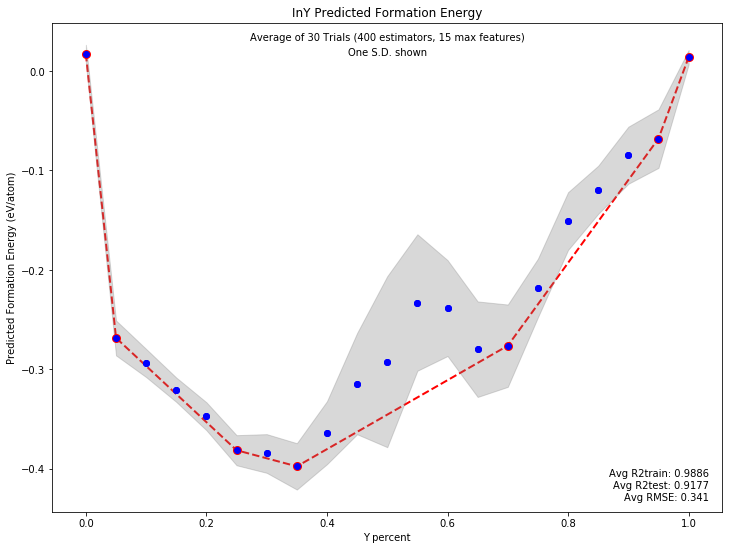

In [14]:
df_binary = pd.read_excel('{0}_predict.xlsx'.format(system))

from scipy.spatial import ConvexHull
x_vals = np.array(df_binary[['{} percent'.format(e2)]])
x_vals = np.concatenate(x_vals)

scatter = np.array(df_binary[['%s percent' % (e2),'Value']])
hull = ConvexHull(scatter)
hull_verts = []
hull_verts.append(hull.points[0])
for vertex in hull.vertices:
    if hull.points[vertex][1] <= 0:
        hull_verts.append(hull.points[vertex])
hull_verts.append(hull.points[-1])        
hull_verts = np.stack(hull_verts)

fig,ax = plt.subplots(figsize=(12,9))
ax.fill_between(x_vals,val_stats[:,0]+val_stats[:,1],val_stats[:,0]-val_stats[:,1],alpha = 0.3,color = 'grey')
ax.scatter(x_vals,val_stats[:,0],color = 'blue')

ax.plot(hull_verts[:,0], hull_verts[:,1], 'r--', lw=2,zorder = 0)
ax.scatter(hull_verts[:,0],hull_verts[:,1],edgecolors = 'red',linewidths = 3)
ax.scatter(df_binary['%s percent' % e2],df_binary['Value'],color = 'blue')
ax.set_title('{0} Predicted Formation Energy'.format(system))

stats = np.stack(stats)
avg_r2train = round(np.average(stats[:,0]),4)
avg_r2test = round(np.average(stats[:,1]),4)
avg_rmse = round(np.average(stats[:,3]),4)

plt.text(0.5, .98, s = 'Average of {0} Trials ({1} estimators, {2} max features)'.format(n_samples,ne,mf),horizontalalignment='center',verticalalignment='top', transform=ax.transAxes)
plt.text(0.98,.02, s='Avg R2train: {0}\nAvg R2test: {1}\nAvg RMSE: {2}'.format(avg_r2train,avg_r2test,avg_rmse),horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes)
plt.text(0.5, 0.95, s = 'One S.D. shown',horizontalalignment = 'center', verticalalignment = 'top', transform = ax.transAxes)
plt.xlabel('{} percent'.format(e2))
plt.ylabel('Predicted Formation Energy (eV/atom)')

### Ternary Phase Diagram

In [15]:
import re

def PCDFinder(e1,e2,e3):
    df = pd.read_excel('PCD2019_comp.xlsx')
    comps = np.concatenate(df.to_numpy())
    targets = []
    
    # define the root (first) letters for each element, so as to not include 'C' containing compounds when searching for 'Ca'
    e1_first,e2_first,e3_first = 'none','none','none'
    if len(e1) == 2:
        e1_first = e1[0]
    if len(e2) == 2:
        e2_first = e2[0]
    if len(e3) == 2:
        e3_first = e3[0]
    
    # from a list of all elements, create a bad element list including all elements not defined as targets or roots to check against each composition  
    elements = ['H','D','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og']
    bad_elem_list = []

    for element in elements:
        if all([element!=e1,element!=e2,element!=e3,element!=e1_first,element!=e2_first,element!=e3_first]):
            bad_elem_list.append(element)
            
    
    # for each composition, check to see if it contains a bad element, or if a root element is followed directly by a number, capital letter, or parentheses
    # if any of these conditions are met, flag the compound as bad and do not use it, otherwise append it to the list
    for comp in comps:
        if any([re.findall(e1,comp) != [],re.findall(e2,comp) != [],re.findall(e3,comp) != []]):
            flag = 0
            for badelem in bad_elem_list:
                if all([re.findall(badelem,comp) != [],flag ==0]):
                    flag = 1
            if flag == 0:
                if any([re.findall('{0}[0-9]'.format(e1_first),comp)!=[],
                        re.findall('{0}[A-Z]'.format(e1_first),comp)!=[],
                        re.findall('{0}\)'.format(e1_first),comp)!=[],
                        re.findall('{0}$'.format(e1_first),comp)!=[],
                        re.findall('{0}[0-9]'.format(e2_first),comp)!=[],
                        re.findall('{0}[A-Z]'.format(e2_first),comp)!=[],
                        re.findall('{0}\)'.format(e2_first),comp)!=[],
                        re.findall('{0}$'.format(e2_first),comp)!=[],
                        re.findall('{0}[0-9]'.format(e3_first),comp)!=[],
                        re.findall('{0}[A-Z]'.format(e3_first),comp)!=[],
                        re.findall('{0}\)'.format(e3_first),comp)!=[],
                        re.findall('{0}$'.format(e3_first),comp)!=[]]):
                    flag = 1
            if flag == 0:
                targets.append(comp)
    targets.append(e1)
    targets.append(e2)
    targets.append(e3)
    
    # define a new list to split each found compound into it's individual elements and stoichs
    # i.e. ['YAg0.88'] --> ['Y1','Ag0.88','In0'] for a Y-Ag-In system
    split_targets = []
    for comp in targets:
        split_targets.append(re.findall('[A-Z][a-z]*[0-9]*\.*[0-9]*',comp))

    # write a dataframe where each value is a numeric entry for that compounds stoichiometry (NOT normalized)
    df = pd.DataFrame(columns = [e1,e2,e3,'Composition'])
    for targetelem in [e1,e2,e3]:    
        for row in range(len(split_targets)):
            for elem in split_targets[row]:
                if re.findall(targetelem,elem) != []:
                    stoich = re.findall('[0-9]+\.*[0-9]*',elem)
                    if stoich == []:
                        stoich = [1]
                    stoich = float(stoich[0])
                    df.at[row,targetelem] = stoich
    
    df = df.fillna(value = 0)
    df.sort_index(axis = 0, ascending = True, inplace = True)
    
    for row in range(len(targets)):
        df['Composition'][row] = str(targets[row])

    return df

import plotly.graph_objects as go

e_above_max = 0.005

fig = go.Figure()

import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.colors as clrs

# Define custom reverse rainbow color map
clrs.PLOTLY_SCALES['Rainbow_r'] = [[0, 'rgb(255,0,0)'],
                                  [0.125, 'rgb(255,111,0)'],
                                  [0.25, 'rgb(255,234,0)'],
                                  [0.375, 'rgb(151,255,0)'],
                                  [0.5, 'rgb(44,255,150)'],
                                  [0.625, 'rgb(0,152,255)'],
                                  [0.75, 'rgb(0,25,255)'],
                                  [0.875, 'rgb(0,0,200)'],
                                  [1, 'rgb(150,0,90)']
                                ]


# Here we are getting the values from our plot.
df = pd.read_excel('%s%s%s_predict.xlsx' % (e1,e2,e3))
e1_per = df['%s' % e1].values
e2_per = df['%s' % e2].values
e3_per = df['%s' % e3].values
y_predict = df['Value'].values



# when we imported the pycalphad.plot.triangular module, it made the 'triangular' projection available for us to use.
fig = ff.create_ternary_contour(np.stack([e1_per,e2_per,e3_per]),
                                 y_predict,
                                pole_labels = [e1,e2,e3],
                                interp_mode='cartesian',
                                ncontours = 20,
                                colorscale= 'Rainbow_r',
                                showscale = True,
                                showmarkers = False,
                                coloring = None,
                                title = {
                                    'text':'{0}-{1}-{2} (20 Trials, 400 Est, 15 MF, {3}eV above hull shown)'.format(e1,e2,e3,e_above_max),
                                    'x':0.5,
                                    'y':0.9,
                                    'xanchor':'center',
                                    'yanchor':'top'
                                },
                                width = 800,
                                height = 800
                               )                                   

# START PLOTTING FACETS
from pymatgen import Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PDEntry, Element

comps = df['Composition']
Ef=df['Value']

mg_comp=[None]*len(comps)
for i in range(len(comps)):
    mg_comp[i]=Composition(comps[i])
    
from pymatgen.entries import  computed_entries

entries3=[None]*len(mg_comp)
for i in range(len(mg_comp)):
    entries3[i]=PDEntry(composition=mg_comp[i], energy=Ef[i])
    
pd3 = PhaseDiagram(entries3)
pd3_stable = [None]*len(pd3.stable_entries)
simps = []
for phase in pd3.stable_entries:
    chempots = pd3.get_all_chempots(phase.composition)
    for keys, values in chempots.items():
        simps.append(keys)

# remove duplicates
simps = list(set(simps))
for i,simplex in enumerate(simps):
    simps[i] = simplex.split('-')
    simps[i].append(simps[i][0])
    
import re
elist = [e1,e2,e3]
elist.sort()

for i,simp in enumerate(simps):
    for n,vert in enumerate(simp):
        simps[i][n] = re.findall('[A-Z]+[a-z]*[0-9]*.[0-9]*',mg.Composition(vert).formula)
        for element in [e1,e2,e3]:
            if list(filter(re.compile(rf'{element}.*').match,simps[i][n])) ==[]:
                simps[i][n].append(element+'0')
        simps[i][n].sort()
        for p,element in enumerate(elist):
            simps[i][n][p] = simps[i][n][p].replace(element,'')

for simp in simps:
    a,b,c = [],[],[]
    for n_elem,elem in enumerate([a,b,c]):
        for n_vert,vert in enumerate(simp):
            elem.append(vert[n_elem])
    fig.add_trace(go.Scatterternary({
            'mode': 'lines',
            'a': a,
            'b': b,
            'c': c,
#    'text': df_pcd['Composition'].values,
            'line':{
                'width':1,
                'color':'black'
            }
                }))
### END PLOTTING FACETS


# get PCD phases
df_pcd = PCDFinder(e1,e2,e3)

# define the scatterplot of known phases from PCD
fig.add_trace(go.Scatterternary({
    'mode': 'markers',
    'a': df_pcd[e1].values,
    'b': df_pcd[e2].values,
    'c': df_pcd[e3].values,
    'text': df_pcd['Composition'].values,
    'hoverinfo':'text+name',
    'name': 'PCD',
    'marker': {
        'symbol': 4,
        'color': 'white',
        'size': 12,
        'line': { 'width': 1,
                'color' : 'black'}
    }
}))



# For plotting the convex hull points
from pymatgen import Composition
comp = df['Composition']
Ef = df['Value']

# write compositions in pymatgen
mg_comp=[None]*len(comp)
for i in range(len(comp)):
    mg_comp[i]=Composition(comp[i])
    
from pymatgen.entries import  computed_entries

entries3=[None]*len(mg_comp)
for i in range(len(mg_comp)):
    entries3[i]=PDEntry(composition=mg_comp[i], energy=Ef[i])

from pymatgen.analysis.phase_diagram import PhaseDiagram
pd3 = PhaseDiagram(entries3)

# calculate convex hull points
df['Ehull'] = [pd3.get_e_above_hull(e) for e in entries3]
df_hull = df[df['Ehull'].between(-100,0)] # <-- dataframe of just points on the hull
df_abovehull = df[df['Ehull'].between(0.000000000000001,e_above_max)] # <-- dataframe of points above the hull
writer = pd.ExcelWriter('%s_predict.xlsx' % (system))
df.to_excel(writer,'Sheet1', index = False )
writer.save()

std_scaler = 30/(max(df_hull['StDev']))

# plot above convex hull points
fig.add_trace(go.Scatterternary({
   'mode': 'markers',
    'a': df_abovehull[e1].values,
    'b': df_abovehull[e2].values,
    'c': df_abovehull[e3].values,
    'text': df_abovehull['Composition'].values,
    'name': 'ML Above Hull',
    'hoverinfo': 'text+name',
    'marker': {
        'symbol': 0,
        'color': 'grey',
        'opacity': 0.5,
#        'size' : 10,
        'size': df_abovehull['StDev']*std_scaler,
        'line': { 'width': 2,
                'color': 'black'}
    }
}))



# plot convex hull points
fig.add_trace(go.Scatterternary({
   'mode': 'markers',
    'a': df_hull[e1].values,
    'b': df_hull[e2].values,
    'c': df_hull[e3].values,
    'text': df_hull['Composition'].values,
    'name': 'ML Convex Hull',
    'hoverinfo': 'text+name',
    'marker': {
        'symbol': 0,
        'color': 'red',
        'opacity': 1.0,
#        'size' : 10,
        'size': df_hull['StDev']*std_scaler,
        'line': { 'width': 2,
                'color': 'black'}
    }
}))

# retitle and rename some features of the plot
fig.update_layout({
    'ternary':
        {
        'sum':1,
        'bgcolor':'white',
        'aaxis':{'title': e1, 'min': 0, 'linewidth':1, 'ticks':'outside', 'linecolor':'black' },
        'baxis':{'title': e2, 'min': 0, 'linewidth':1, 'ticks':'outside', 'linecolor':'black' },
        'caxis':{'title': e3, 'min': 0, 'linewidth':1, 'ticks':'outside', 'linecolor':'black' }
    }
})


fig.show()

In [18]:
import os

if not os.path.exists("images"):
    os.mkdir("images")
    
fig.write_image("images/fig1.svg")